In [98]:
import asyncio
from copra.websocket import Channel, Client
import matplotlib.pyplot as plt
from collections import OrderedDict
from time import sleep
from dateutil import parser
import copy
import datetime
import itertools
from operator import itemgetter
import numpy as np
from dateutil.tz import tzutc
import math
import pytz
from pytz import timezone
import pickle
import pylab
from scipy.stats import probplot,expon,kstest

# Load Data

In [93]:
with open('12_23_18_data.pkl','rb') as f:
    updates,starting_time,K,starting_book,starting_ref_price = pickle.load(f)
    
len(updates)

10798

# Combine Updates that Occur At Same Time

In [94]:
grouped_by_time = OrderedDict([(k, list(v)) for k, v in itertools.groupby(updates, key=lambda x:x['time'])])
# Contains dictionary of time, reference price, order book, list of changes
cleaned_updates = []
for t, us in grouped_by_time.items():
    if len(us) == 1:
        u = us[0]
        cleaned_updates.append(copy.copy(u))
    else:
        new_update = {'time': t}
        us = sorted(us, key=lambda u:-abs(u['k']))
        grouped_by_k = OrderedDict((k, list(v)) for k, v in itertools.groupby(us, key=lambda u:u['k']))
        reference_k = list(grouped_by_k.keys())[0]
        new_update['reference_price'] = grouped_by_k[reference_k][0]['reference_price']
        new_update['LOB'] = copy.copy(grouped_by_k[reference_k][0]['LOB'])
        events = []
        for k in grouped_by_k:
            combined_change = 0
            for u in grouped_by_k[k]:
                combined_change = combined_change + u['change']
            events.append((k,combined_change))
        for k,change in events:
            new_update = copy.deepcopy(new_update)
            new_update['k'] = k
            new_update['change'] = change
            cleaned_updates.append(new_update)

cleaned_updates
len(cleaned_updates)

10642

# Combine Orders that Occur in Quick Succession
### (Orders that occur within 0.01 seconds of each other)

In [95]:
combined_updates = []
i = 0
while i < len(cleaned_updates):
    reference_price = cleaned_updates[i]['reference_price']
    j = i
    updates_at_reference = []
    while (j < len(cleaned_updates)) and (cleaned_updates[j]['reference_price'] == reference_price):
        updates_at_reference.append(cleaned_updates[j])
        j += 1
    updates_at_reference = sorted(updates_at_reference,key=lambda u:u['k'])
    grouped_by_k = OrderedDict((k, list(v)) for k, v in itertools.groupby(updates_at_reference, key=lambda u:u['k']))
    for k,us in grouped_by_k.items():
        us = copy.deepcopy(sorted(us,key=lambda u:u['time']))
        keep_index = [True for u in us]
        for m in reversed(range(1,len(us))):
            quick_same_order = (us[m]['time'] - us[m-1]['time']).total_seconds() < 0.01
            same_sign = (us[m]['change'] * us[m-1]['change']) > 0
            if quick_same_order and same_sign:
                us[m-1]['change'] += us[m]['change']
                keep_index[m] = False
        for (u,keep) in zip(us, keep_index):
            if keep:
                combined_updates.append(u)
    i = j + 1
    
combined_updates = sorted(combined_updates,key=lambda u:u['time'])
len(combined_updates)

10223

# Calculate Average Event Size at Each Position

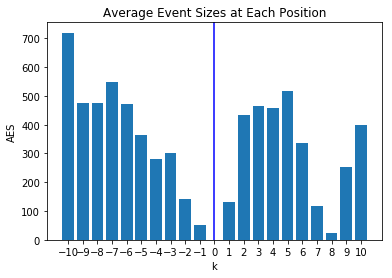

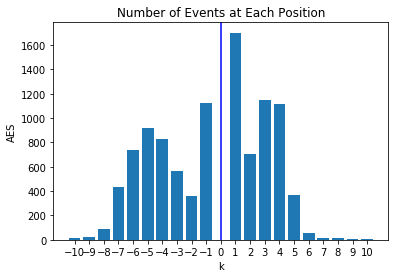

In [96]:
# Get Average Event Sizes
event_sizes = OrderedDict([(i,[]) for i in range(-K,K+1) if i != 0])
for update in combined_updates:
    event_sizes[update['k']].append(abs(update['change']))
AESs = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
numbers_of_events = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
for (k,event_sizes) in event_sizes.items():
    AESs[k] = np.mean(event_sizes)
    numbers_of_events[k] = len(event_sizes)
    
k,AES = zip(*AESs.items())
        
b1 = plt.bar(k, AES)
v = plt.axvline(x=0, color='b')
plt.xticks([i for i in range(-K,K+1)])        
plt.title('Average Event Sizes at Each Position')
plt.xlabel('k')
plt.ylabel('AES')
plt.show()

k,number_of_events = zip(*numbers_of_events.items())
b1 = plt.bar(k, number_of_events)
v = plt.axvline(x=0, color='b')
plt.xticks([i for i in range(-K,K+1)])        
plt.title('Number of Events at Each Position')
plt.xlabel('k')
plt.ylabel('AES')
plt.show()

# Get time between events at each position and queue size

In [97]:
def transform_book(book):
    res = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
    for k,actual_size in book.items():
        if math.isnan(AESs[k]):
            size = 1
        else:
            size = int(actual_size / AESs[k])
        res[k] = size
    return res

# Get times between events
maximum_sizes = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
for update in combined_updates:
    transformed_book = transform_book(update['LOB'])
    for k,size in transformed_book.items():
        if size > maximum_sizes[k]:
            maximum_sizes[k] = size
            
time_between_events_pos = OrderedDict([(k,OrderedDict()) for k in range(-K,K+1) if k != 0])
time_between_events_neg = OrderedDict([(k,OrderedDict()) for k in range(-K,K+1) if k != 0])

for k in range(-K,K+1):
    if k != 0:
        for i in range(maximum_sizes[k] + 1):
            time_between_events_pos[k][i] = []
        for i in range(1,maximum_sizes[k] + 1):
            time_between_events_neg[k][i] = []           
                
t = starting_time
reference_change_time = t
last_change_time_at_k = OrderedDict([(k,reference_change_time) for k in range(-K,K+1) if k != 0])
old_reference_price = starting_ref_price

for update in combined_updates:
    reference_price = update['reference_price']
    transformed_book = transform_book(update['LOB'])
    t = update['time']
    if reference_price != old_reference_price:
        last_change_time_at_k = OrderedDict([(k,reference_change_time) for k in range(-K,K+1) if k != 0])
        reference_change_time = t
        old_reference_price = reference_price

    k = update['k']
    time_between_change = (t-last_change_time_at_k[k]).total_seconds()
    size = transformed_book[k]
    if update['change'] > 0:
        time_between_events_pos[k][size].append(time_between_change)
        last_change_time_at_k[k]= t
    else:
        if size > 0:
            time_between_events_neg[k][size].append(time_between_change)
            last_change_time_at_k[k] = t 

# QQ Plots of Times Between Events Compared to Exponential Distribution

In [106]:
def without_outliers(data):
    quartiles = np.percentile(data,[25,50,75])
    IQR = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - 2*IQR
    upper_bound = quartiles[2] + 2*IQR
    return [d for d in data if d >= lower_bound and d <= upper_bound]

for k in time_between_events_pos:
    for size in time_between_events_pos[k]:
        if len(time_between_events_pos[k][size]) < 10:
            del time_between_events_pos[k][size]
            continue
        time_between_events_pos[k][size] = without_outliers(time_between_events_pos[k][size])
        
for k in time_between_events_neg:
    for size in time_between_events_neg[k]:
        time_between_events_neg[k][size] = without_outliers(time_between_events_neg[k][size])        
        
for k,v in time_between_events_pos.items():
    if k > 5 or k <= -7:
        continue
    for size,times in v.items():
        n = len(times)
        if num_all_observations < 10:
            continue
        print("k = {}, size = {}".format(k,size))
        print("Number of positive jump times: {}".format(n))
        num_data_points = len(times)
        print("Mean: {}".format(np.mean(times)))
        if num_data_points < 10:
            print("\n")
            continue
        probplot(times, dist=expon, plot=pylab)
        pylab.show()
        print("\n")

for k,v in time_between_events_neg.items():
    if k > 5 or k <= -7:
        continue
    for size,times in v.items():
        n = len(times)
        if num_all_observations < 10:
            continue
        print("k = {}, size = {}".format(k,size))
        print("Number of negative jump times: {}".format(n))
        num_data_points = len(times)
        print("Mean: {}".format(np.mean(times)))
        if num_data_points < 10:
            print("\n")
            continue
        probplot(times, dist=expon, plot=pylab)
        pylab.show()
        print("\n")

RuntimeError: OrderedDict mutated during iteration

In [73]:
def without_outliers(data):
    return [d for d in data if d <= np.median(data)*median_multiplier]
    
for k,v in time_between_events_pos.items():
    for size,times in v.items():
        print("k = {}, size = {}".format(k,size))
        num_all_observations = len(times)
        print("Number of positive jump times: {}".format(num_all_observations))
        times = without_outliers(times)
        num_data_points = len(times)
        print("Number of outliers: {}".format(num_data_points - num_all_observations))
        print("Mean: {}".format(np.mean(times)))
        if num_data_points < 10:
            continue
        stats.probplot(data, dist=stats.expon, plot=pylab)
        pylab.show()
        print("\n")

NameError: name 'time_between_events_pos' is not defined

In [ ]:
for k,v in time_between_events_neg.items():
    for size,times in v.items():
        print("k = {}, size = {}".format(k,size))
        num_all_observations = len(times)
        print("Number of positive jump times: {}".format(num_all_observations))
        times = without_outliers(times)
        num_data_points = len(times)
        print("Number of outliers: {}".format(num_data_points - num_all_observations))
        if num_data_points < 10:
            continue
        stats.probplot(data, dist=stats.expon, plot=pylab)
        pylab.show()
        print("\n")

In [60]:
data = sorted([0.056, 0.059, 0.016, 0.29, 1.011, \
        0.001, 0.029, 0.028, 0.218, .338, \
        0.222, 0.642, 1.978, 0.989, 0.992, 0.984, 0.091, 1.98, \
        0.986, 1.462, 0.001, 0.057, 0.013])
data = [d for d in data if d <= np.median(data)*median_multiplier]
data

[0.001,
 0.001,
 0.013,
 0.016,
 0.028,
 0.029,
 0.056,
 0.057,
 0.059,
 0.091,
 0.218,
 0.222,
 0.29,
 0.338,
 0.642,
 0.984,
 0.986,
 0.989,
 0.992,
 1.011,
 1.462]

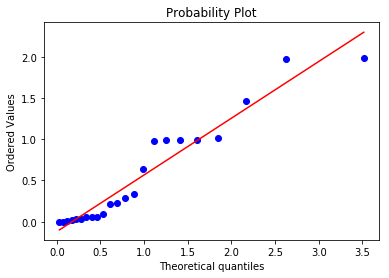

In [49]:
import numpy as np 
import pylab 
import scipy.stats as stats
 
stats.probplot(data, dist=stats.expon, plot=pylab)
pylab.show()

67
67


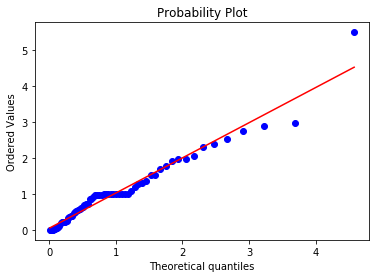

In [62]:
data = [0.05, 0.227, 0.229, 0.525, 0.615, 1.28, 0.696, 0.078, 0.401, 0.732, 0.231, \
0.509, 0.053, 1.2, 0.003, 0.016, 0.004, 0.991, 0.989, 0.918, 2.4, 0.987, \
0.99, 2.529, 0.019, 1.979, 0.868, 1.097, 0.009, 0.991, 0.961, 0.209, 1.681, 0.969, \
1.982, 0.987, 0.008, 1.541, 0.857, 2.965, 5.493, 0.467, 1.775, \
0.4, 1.519, 2.897, 0.118, 2.763, 0.645, 0.239, 0.998, 0.981, 0.183, 0.99, 0.989, \
0.365, 0.988, 0.336, 0.974, 1.308, 2.053, 2.311, 0.563, 1.365, 1.93, 0.729, 0.571]

print(len(data))

data = [d for d in data if d <= np.median(data)*median_multiplier]
print(len(data))
import numpy as np 
import pylab 
import scipy.stats as stats
 
stats.probplot(data, dist=stats.expon, plot=pylab)
pylab.show()

In [38]:
data = sorted([0.161, 0.083, 0.424, 0.457, 0.966, 0.444, 0.392, 0.395, 0.341, \
         1.058, 0.518, 0.838, 0.477, 0.557, 0.548, 2.222, 0.294, 0.668, \
         0.504, 0.528, 0.483, 1.755, 0.742, 0.421, 0.812, 0.337, 0.418, \
         0.367, 1.132, 0.708, 0.662, 0.378, 1.402, 0.913, 0.346, 1.959, \
         0.539, 1.221, 0.681, 0.005, 0.003, 0.002, 0.028, 2.012, 0.861, \
         0.67, 0.315, 0.884, 0.296, 0.088, 0.106, 1.456])

data

[0.002,
 0.003,
 0.005,
 0.028,
 0.083,
 0.088,
 0.106,
 0.161,
 0.294,
 0.296,
 0.315,
 0.337,
 0.341,
 0.346,
 0.367,
 0.378,
 0.392,
 0.395,
 0.418,
 0.421,
 0.424,
 0.444,
 0.457,
 0.477,
 0.483,
 0.504,
 0.518,
 0.528,
 0.539,
 0.548,
 0.557,
 0.662,
 0.668,
 0.67,
 0.681,
 0.708,
 0.742,
 0.812,
 0.838,
 0.861,
 0.884,
 0.913,
 0.966,
 1.058,
 1.132,
 1.221,
 1.402,
 1.456,
 1.755,
 1.959,
 2.012,
 2.222]

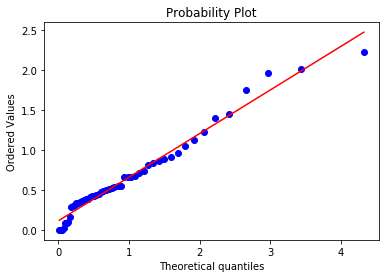

In [39]:
import numpy as np 
import pylab 
import scipy.stats as stats
 
stats.probplot(data, dist=stats.expon, plot=pylab)
pylab.show()